# Solubility modeling pipeline (CNN vs QNN vs Hybrid)

End-to-end notebook that keeps all preprocessing, training, evaluation, and comparison in one place. The flow mirrors the desired
pipeline:

1. Clean AqSolDB SMILES and write `train/val/test` splits.
2. Train three models (CNN over tokenized SMILES, pure QNN over RDKit descriptors, hybrid classical+QNN).
3. Save weights and helper artifacts for every model.
4. Test on the held-out split **and** on four chemistry-driven series (relative baseline, stress test, alcohol chain length, aromatic substitutions).
5. Report RMSE, MAE, R2, and rough training runtime so the three models can be compared side by side.

Run cells top-to-bottom; every section is heavily commented so it can double as executable documentation.

In [47]:
# Standard libs and project paths
import json, os, random, sys, time
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from rdkit import RDLogger
RDLogger.DisableLog("rdApp.warning")

# Keep everything relative to the repo root
PROJECT_ROOT = Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
RESULTS_DIR = PROJECT_ROOT / 'results'
for d in (ARTIFACTS_DIR, RESULTS_DIR):
    d.mkdir(exist_ok=True, parents=True)

# Reproducibility switches
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

# Import local helpers
sys.path.append(str((PROJECT_ROOT / 'src').resolve()))
from chem_utils import canonicalize_and_clean, load_aqsoldb, scaffold_or_random_split, save_split_indices
from cnn_utils import build_vocab, SmilesDataset, SmilesCNN, evaluate as evaluate_cnn

Using device: cpu


## Data cleaning and scaffold split

All preprocessing happens here so the notebook is self-contained. If the cleaned/split CSVs already exist they will simply be
overwritten with the freshly computed versions, keeping the run reproducible.

In [48]:
RAW_CSV = DATA_DIR / 'aqsoldb.csv'
CLEAN_CSV = DATA_DIR / 'aqsoldb_clean.csv'
TRAIN_CSV = DATA_DIR / 'train.csv'
VAL_CSV = DATA_DIR / 'val.csv'
TEST_CSV = DATA_DIR / 'test.csv'

# Load raw data and canonicalize SMILES (drops invalid rows and coerces the target to numeric)
df_raw = load_aqsoldb(RAW_CSV)
df_clean = canonicalize_and_clean(df_raw)
print(df_clean.head())
print(f'\nLoaded {len(df_raw)} rows, kept {len(df_clean)} after cleaning.')

# Scaffold split (falls back to random split if scaffolds fail); save both indices and CSVs
train_idx, val_idx, test_idx = scaffold_or_random_split(df_clean, seed=SEED)
save_split_indices(train_idx, val_idx, test_idx, ARTIFACTS_DIR)

df_clean.loc[train_idx].to_csv(TRAIN_CSV, index=False)
df_clean.loc[val_idx].to_csv(VAL_CSV, index=False)
df_clean.loc[test_idx].to_csv(TEST_CSV, index=False)
print('Wrote train/val/test CSVs and split indices to data/ + artifacts/.')


[23:43:23] Explicit valence for atom # 5 N, 4, is greater than permitted
[23:43:23] Explicit valence for atom # 5 N, 4, is greater than permitted


    ID                                               Name  \
0  A-3         N,N,N-trimethyloctadecan-1-aminium bromide   
1  A-4                           Benzo[cd]indol-2(1H)-one   
2  A-5                               4-chlorobenzaldehyde   
3  A-8  zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...   
4  A-9  4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...   
4  InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...   

                      InChIKey  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N   
3  XTUPUYCJWKHGSW-UHFFFAOYSA-L   
4  FAUAZXVRLVIARB-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0                C

## Descriptive Statistics

### Explore Data

In [49]:
# check shape of data
df_clean.shape

(9980, 26)

In [50]:
# dtypes
df_clean.dtypes

ID                      object
Name                    object
InChI                   object
InChIKey                object
SMILES                  object
Solubility             float64
SD                     float64
Occurrences              int64
Group                   object
MolWt                  float64
MolLogP                float64
MolMR                  float64
HeavyAtomCount         float64
NumHAcceptors          float64
NumHDonors             float64
NumHeteroatoms         float64
NumRotatableBonds      float64
NumValenceElectrons    float64
NumAromaticRings       float64
NumSaturatedRings      float64
NumAliphaticRings      float64
RingCount              float64
TPSA                   float64
LabuteASA              float64
BalabanJ               float64
BertzCT                float64
dtype: object

In [51]:
# info
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9980 non-null   object 
 1   Name                 9980 non-null   object 
 2   InChI                9980 non-null   object 
 3   InChIKey             9980 non-null   object 
 4   SMILES               9980 non-null   object 
 5   Solubility           9980 non-null   float64
 6   SD                   9980 non-null   float64
 7   Occurrences          9980 non-null   int64  
 8   Group                9980 non-null   object 
 9   MolWt                9980 non-null   float64
 10  MolLogP              9980 non-null   float64
 11  MolMR                9980 non-null   float64
 12  HeavyAtomCount       9980 non-null   float64
 13  NumHAcceptors        9980 non-null   float64
 14  NumHDonors           9980 non-null   float64
 15  NumHeteroatoms       9980 non-null   f

In [52]:
# check missing data 
df_clean.isnull().sum() 

ID                     0
Name                   0
InChI                  0
InChIKey               0
SMILES                 0
Solubility             0
SD                     0
Occurrences            0
Group                  0
MolWt                  0
MolLogP                0
MolMR                  0
HeavyAtomCount         0
NumHAcceptors          0
NumHDonors             0
NumHeteroatoms         0
NumRotatableBonds      0
NumValenceElectrons    0
NumAromaticRings       0
NumSaturatedRings      0
NumAliphaticRings      0
RingCount              0
TPSA                   0
LabuteASA              0
BalabanJ               0
BertzCT                0
dtype: int64

### Summary Stats

In [58]:
import researchpy as rp

df_num = df_clean[['Solubility', 'SD', 'Occurrences', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors', 
                          'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings', 
                          'NumSaturatedRings','NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']]

# summary statistics of numerical variables 
rp.summary_cont(df_num)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Solubility,9980.0,-2.8905,2.3680,0.0237,-2.9369,-2.8440
1,SD,9980.0,0.0675,0.2347,0.0023,0.0629,0.0721
2,Occurrences,9980.0,1.3782,1.0236,0.0102,1.3581,1.3982
3,MolWt,9980.0,266.6943,184.1865,1.8437,263.0803,270.3084
4,MolLogP,9980.0,1.9797,3.5179,0.0352,1.9106,2.0487
5,MolMR,9980.0,66.8015,46.5251,0.4657,65.8886,67.7144
6,HeavyAtomCount,9980.0,17.3764,12.2422,0.1225,17.1361,17.6166
7,NumHAcceptors,9980.0,3.4872,3.4984,0.0350,3.4185,3.5558
8,NumHDonors,9980.0,1.1087,1.4891,0.0149,1.0795,1.1379
9,NumHeteroatoms,9980.0,5.1974,4.7366,0.0474,5.1045,5.2903


### Skewness

In [59]:
# skewness of numerical variables: 0 means no skewness, positive means right skewed, negative means left skewed
df_num.skew()

Solubility            -0.551664
SD                     5.855807
Occurrences            9.689606
MolWt                  5.494657
MolLogP                0.718042
MolMR                  5.595221
HeavyAtomCount         5.811667
NumHAcceptors          4.924793
NumHDonors             3.432706
NumHeteroatoms         4.771572
NumRotatableBonds      5.905892
NumValenceElectrons    5.804495
NumAromaticRings       3.737099
NumSaturatedRings      9.376983
NumAliphaticRings      6.294426
RingCount              3.369024
TPSA                   4.330018
LabuteASA              5.549940
BalabanJ              -0.650519
BertzCT                8.440738
dtype: float64

### Data Visualizations

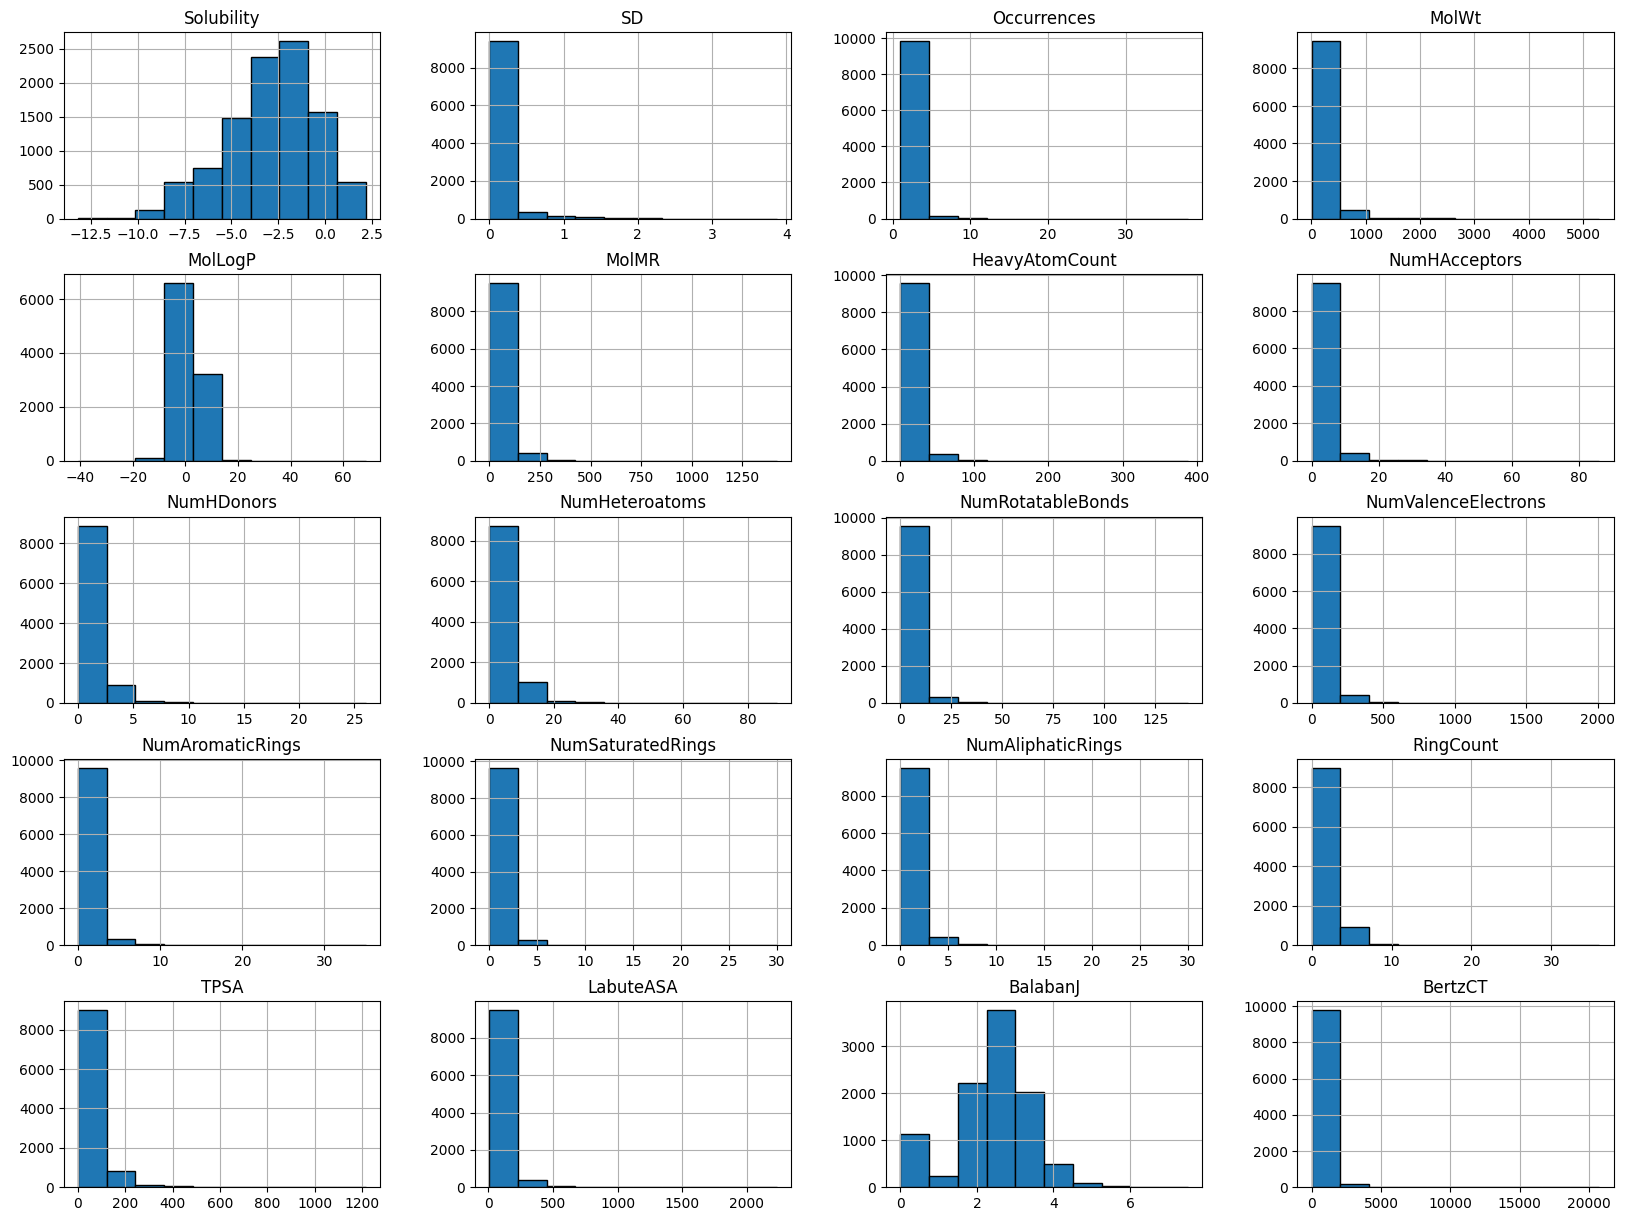

In [61]:
df_num.hist(figsize=(20,15), edgecolor='black')
plt.show()

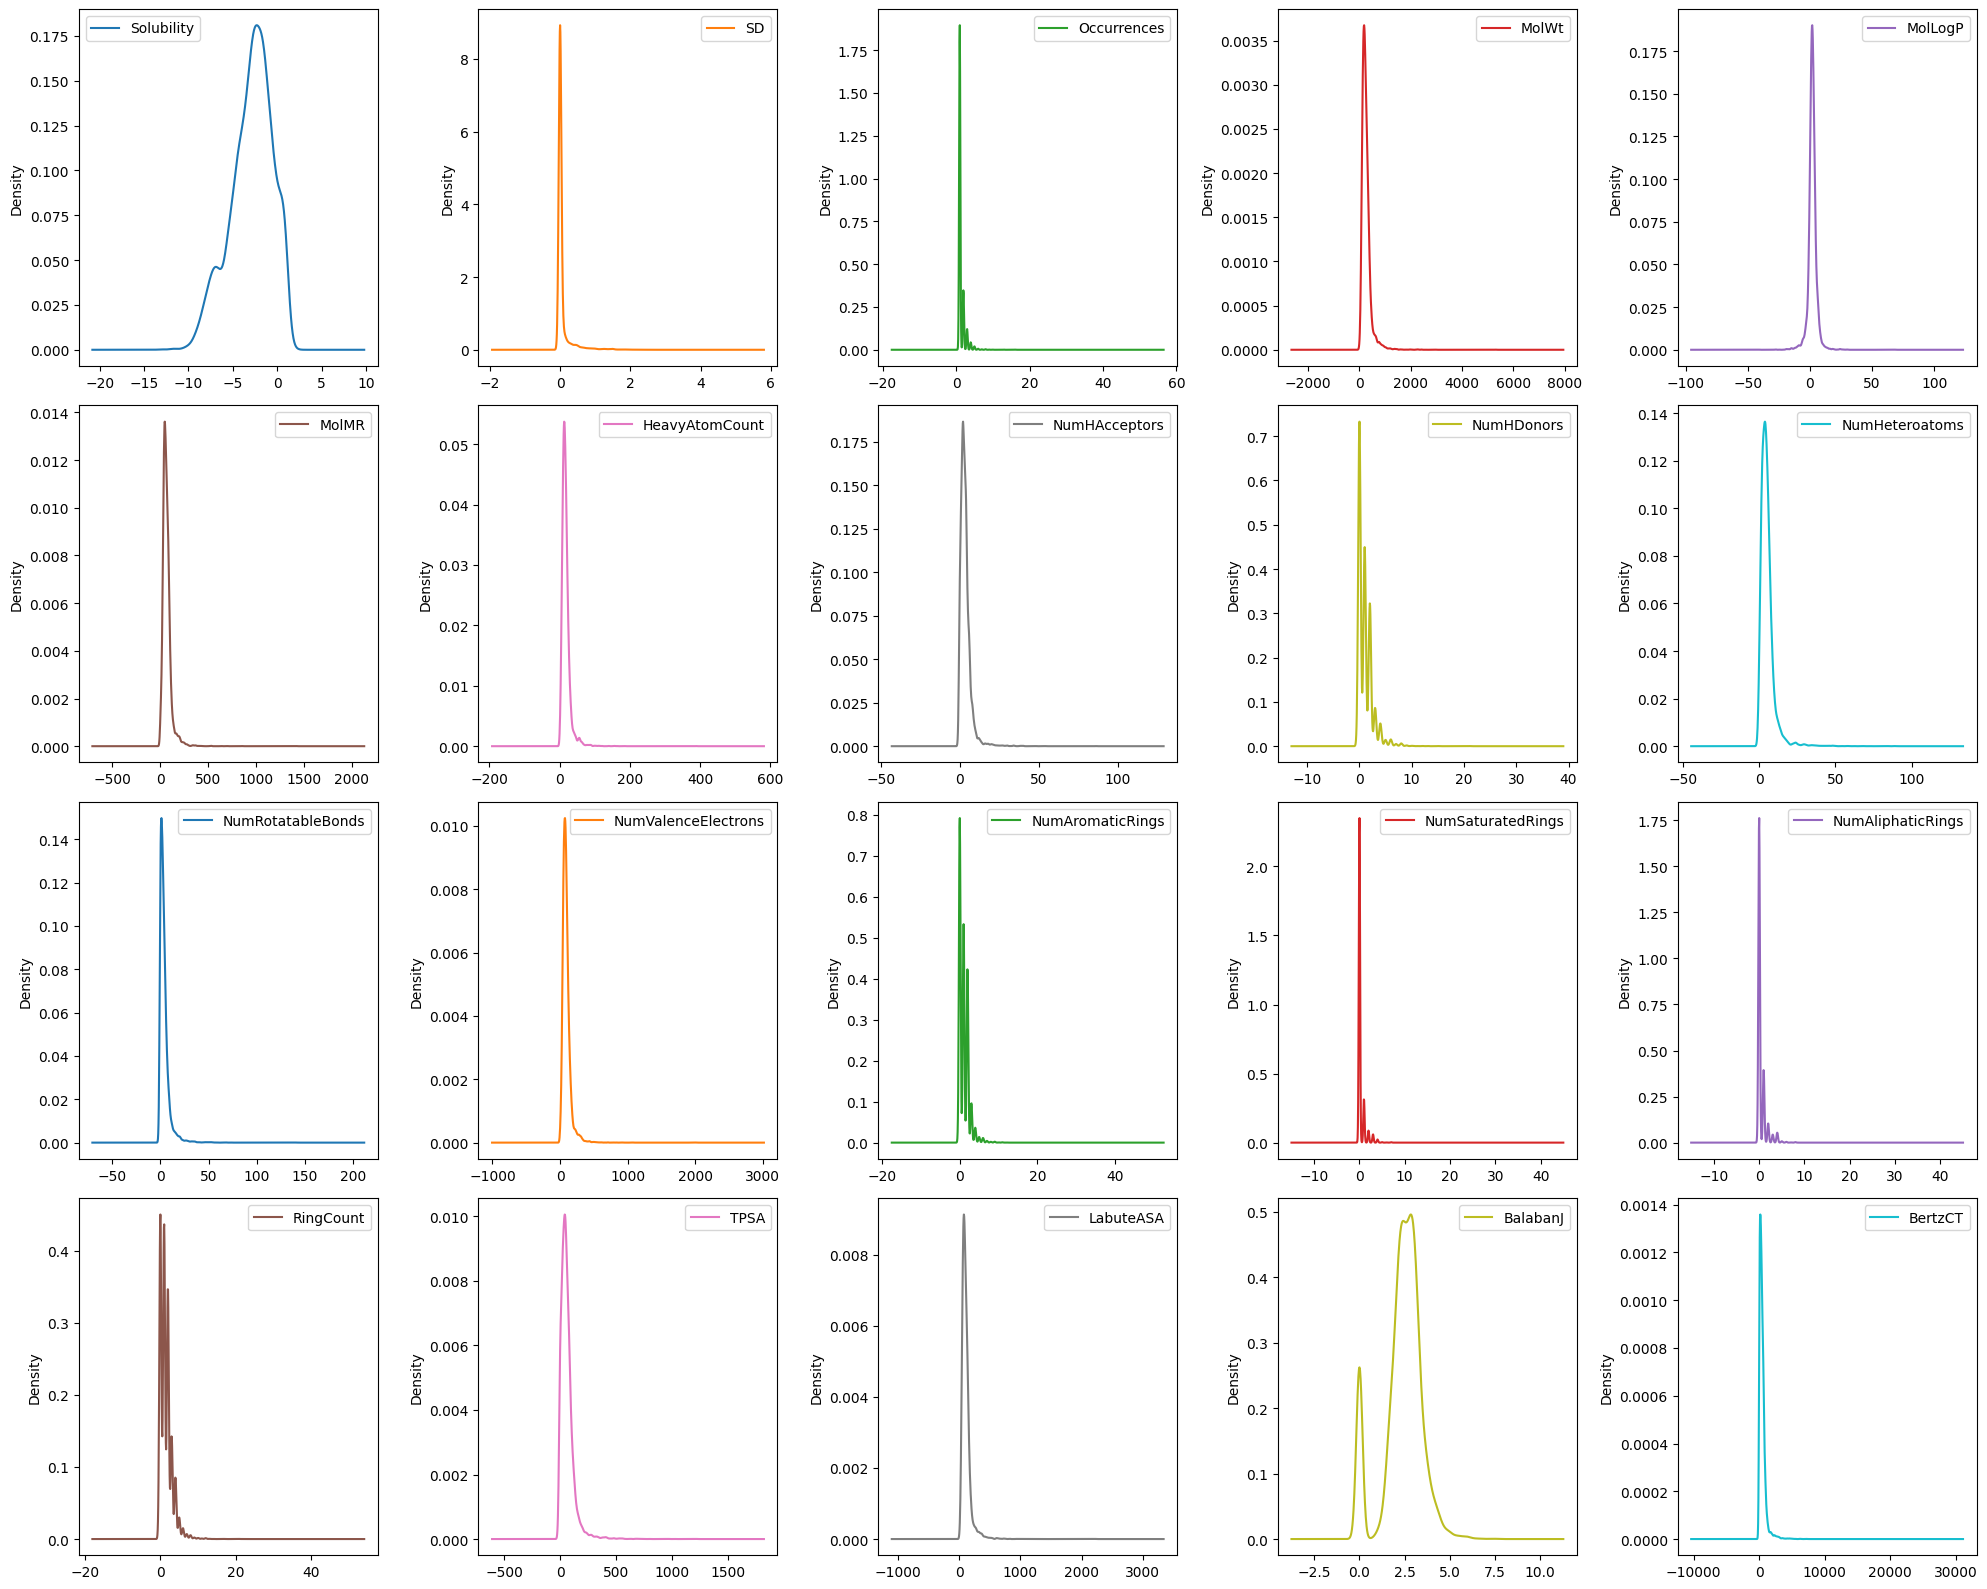

In [65]:
# Univariate distributions with density plot 
df_num.plot(kind = 'density', subplots=True, sharex=False, figsize=(20, 16), layout=(4, 5))
plt.tight_layout()

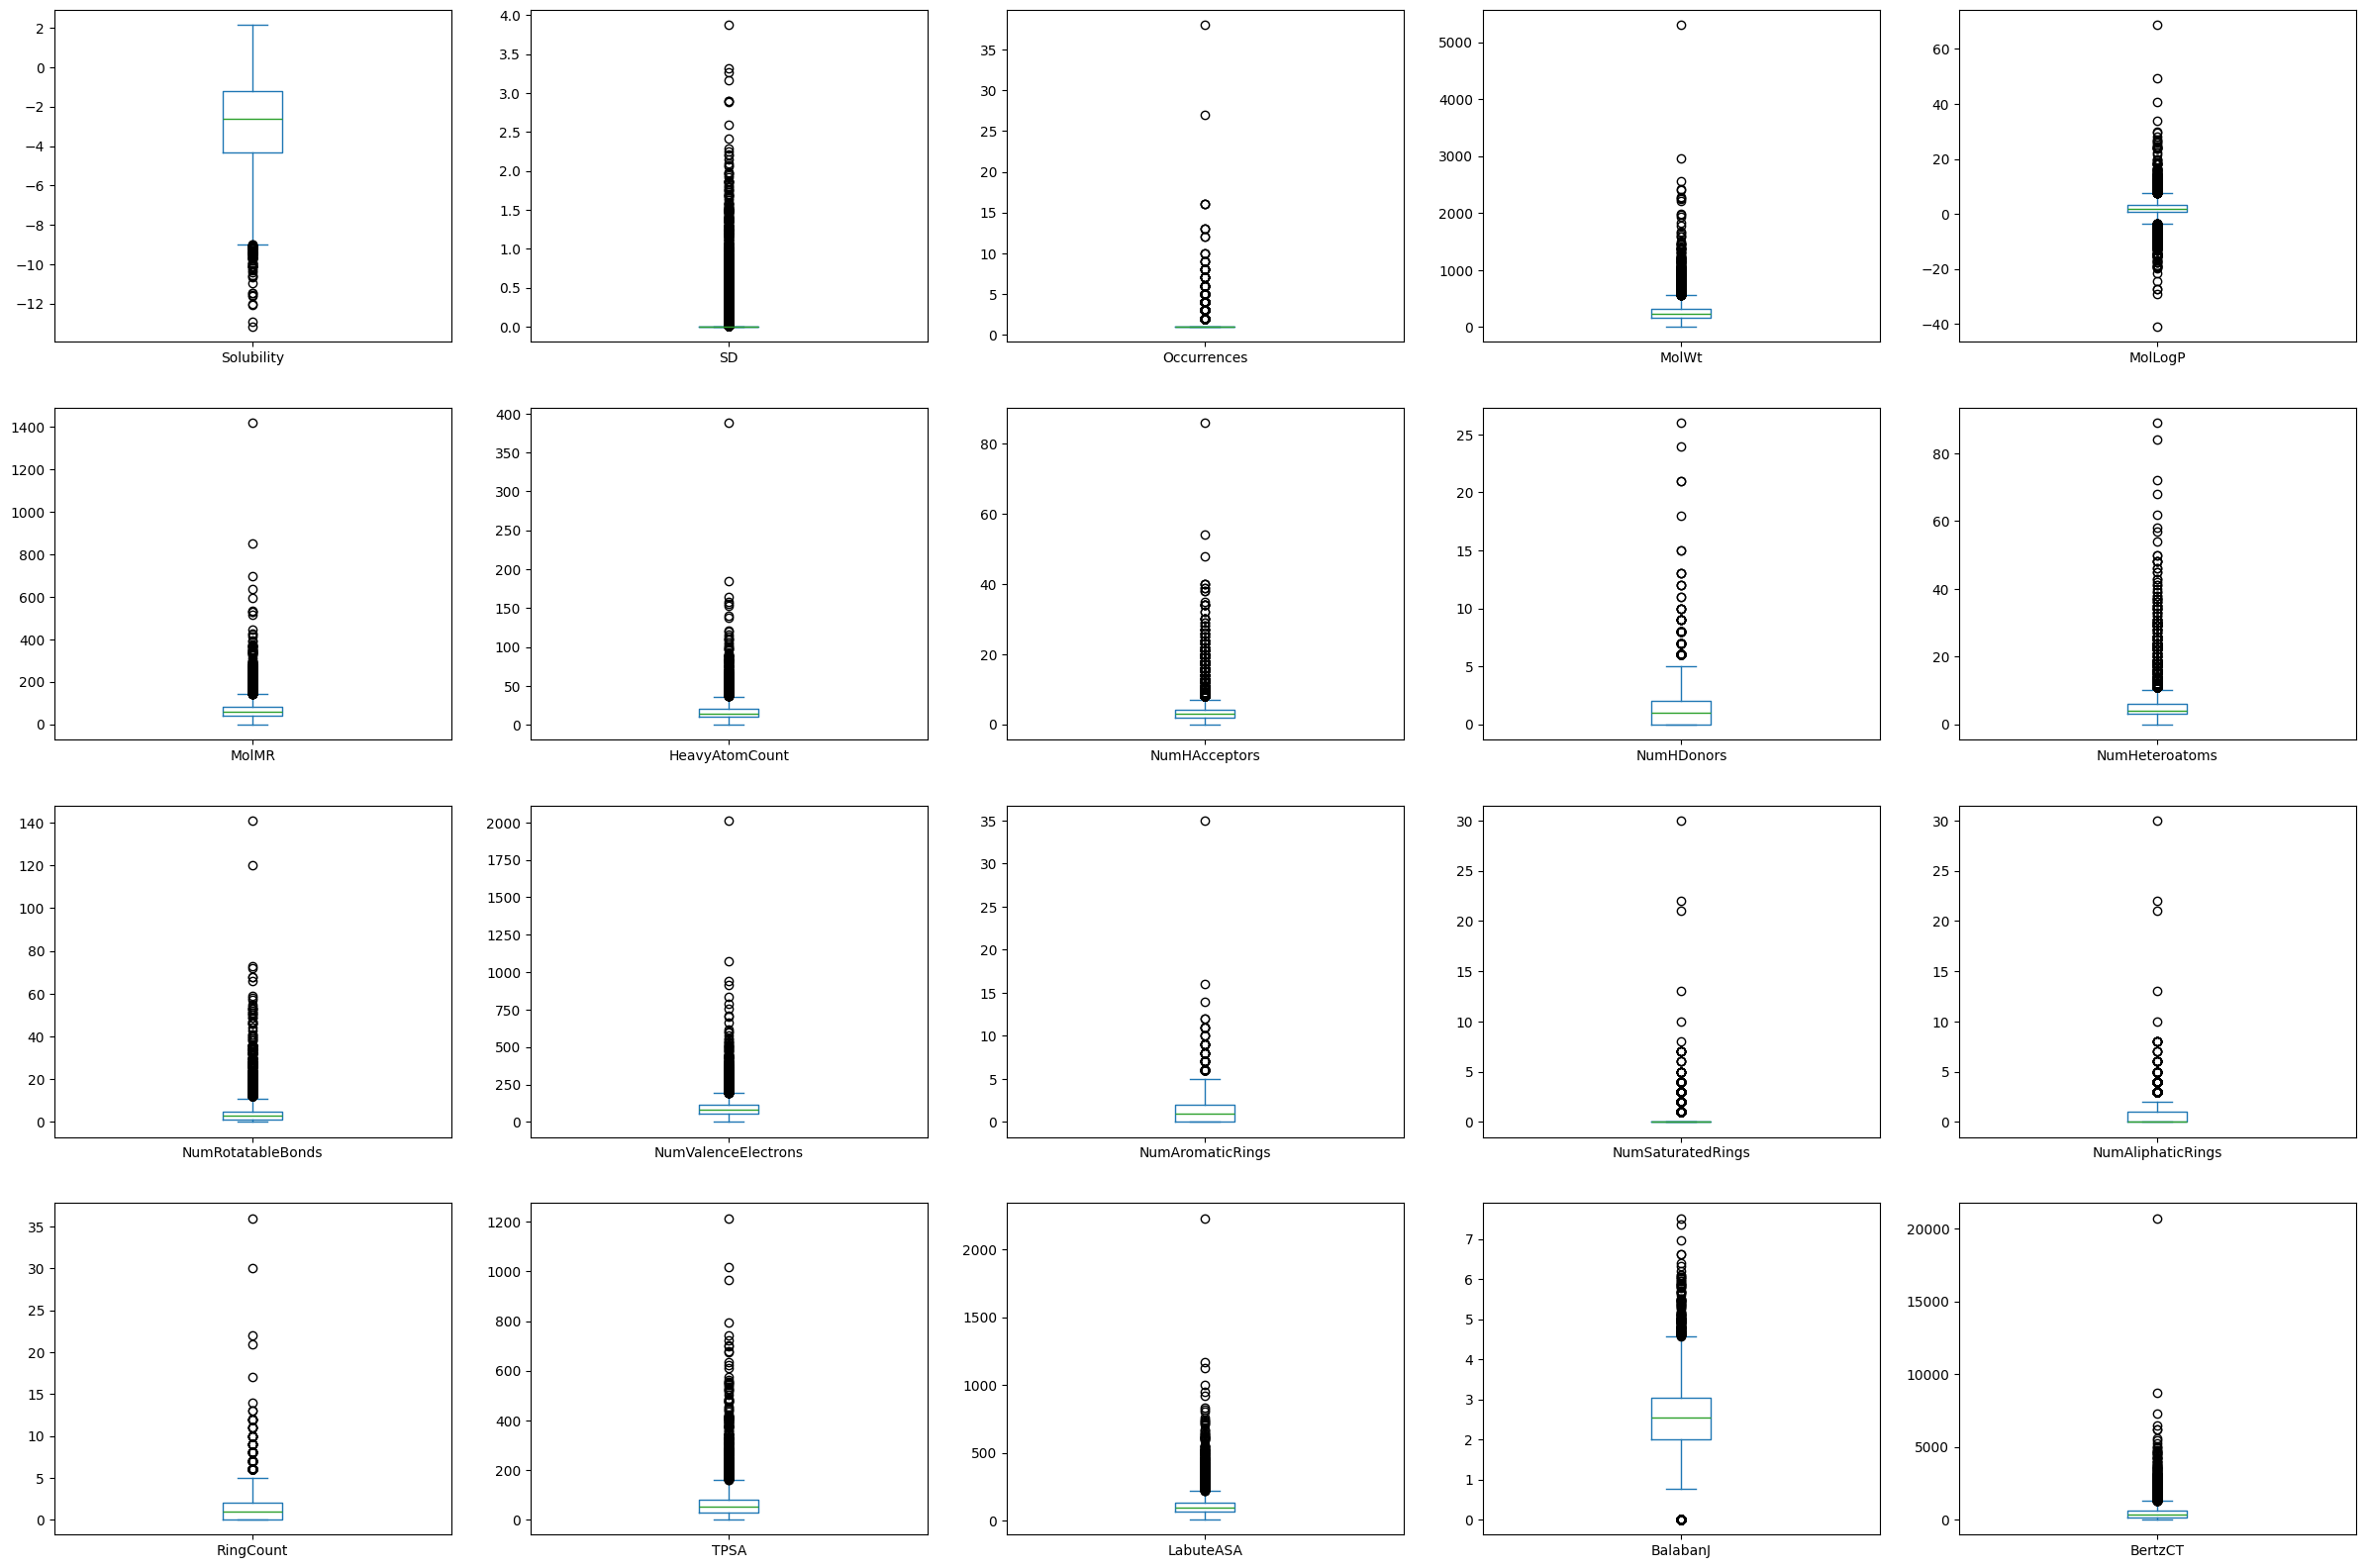

In [67]:
# Univariate distributions with box plots 
df_num.plot(kind='box', subplots=True, sharex=False, figsize=(30,20), layout=(4,5))
plt.show() 

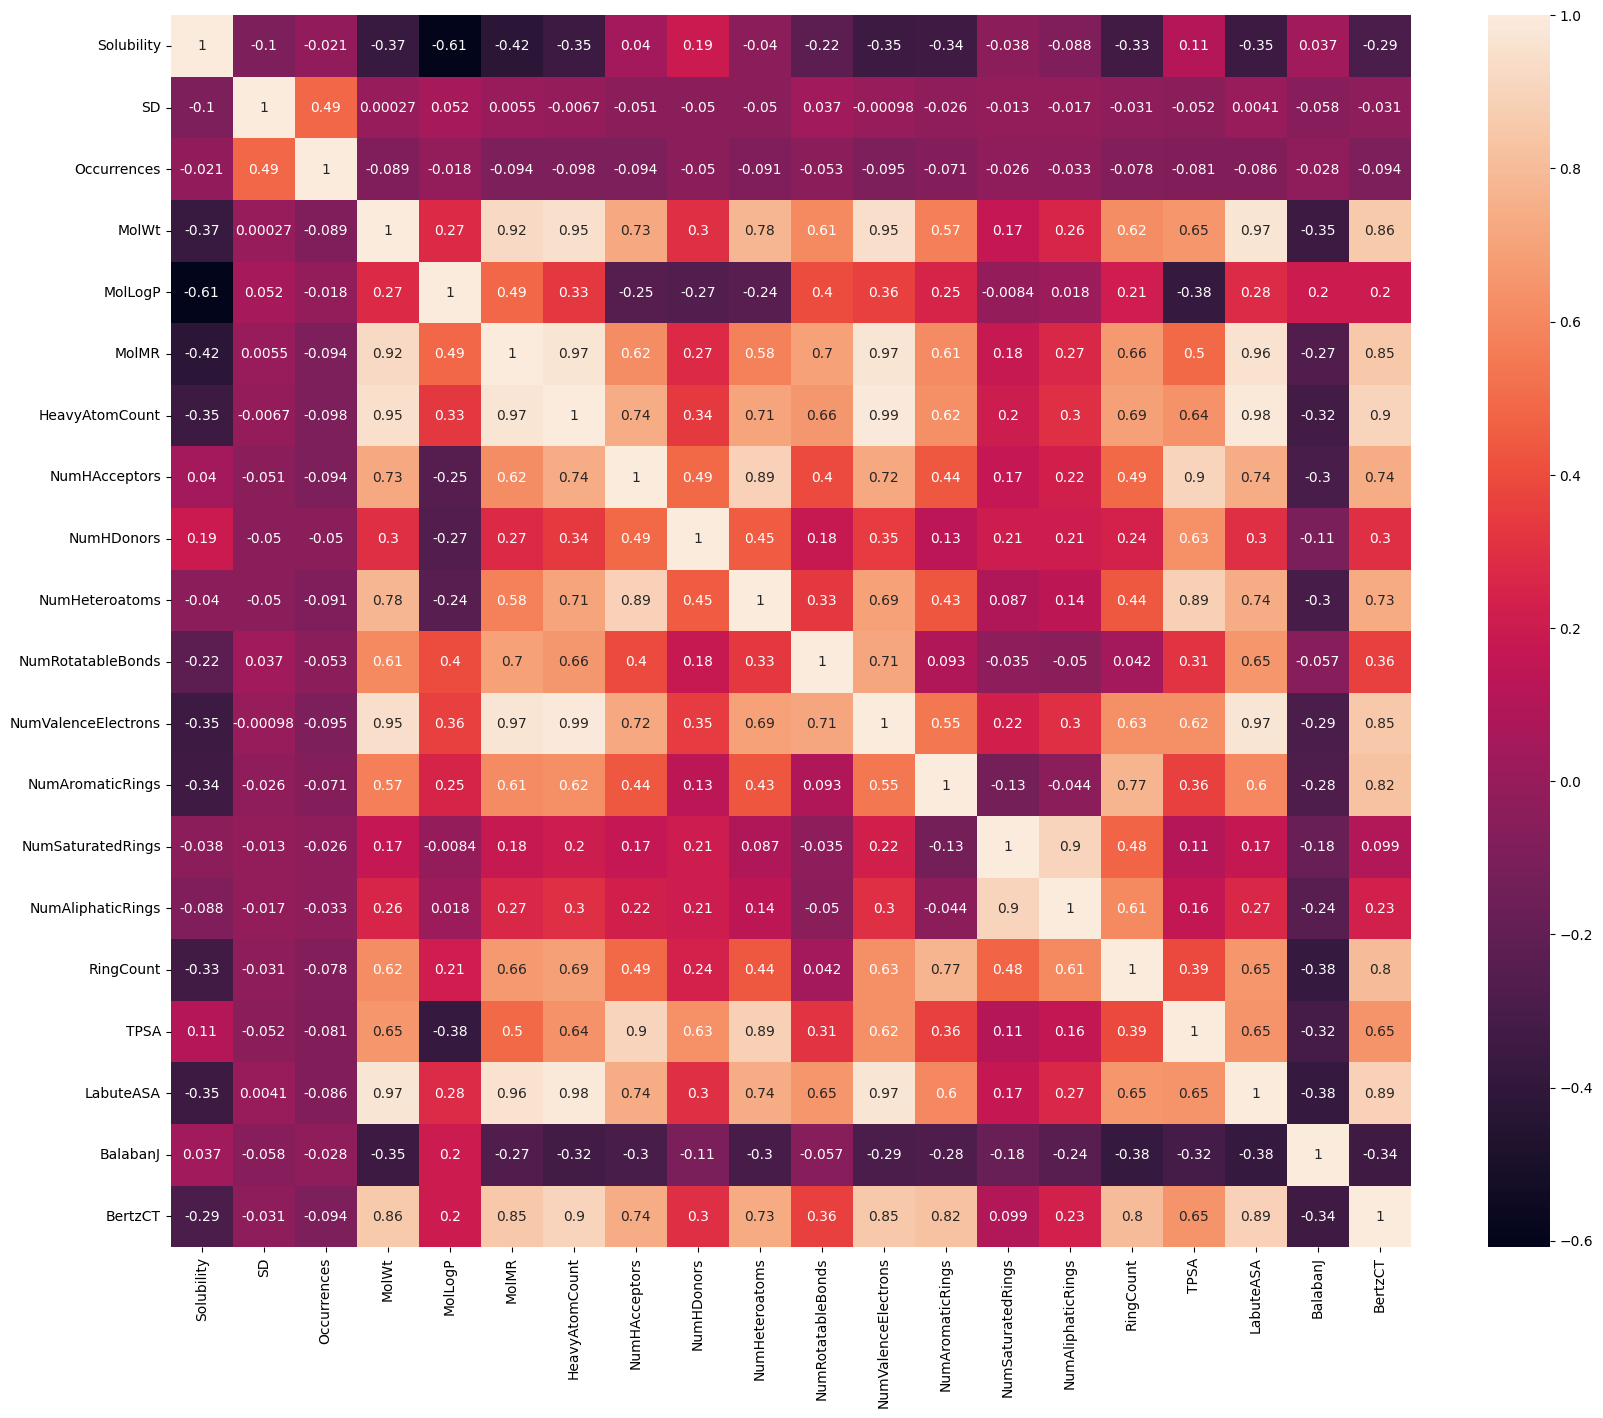

In [69]:
import seaborn as sns
# Multivariate plots with correlations 
plt.figure(figsize=(20,16))
corr = df_num.corr() 
sns.heatmap(corr, annot=True)
plt.show()

## Metrics and series definitions

In [33]:
# Basic regression metrics used across the three models
def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    rmse = float(np.sqrt(((y_true - y_pred) ** 2).mean()))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

# Four chemistry-driven series to probe model behavior beyond aggregate metrics
SERIES = {
    'relative_baseline': {
        'title': 'Relative solubility reference',
        'desc': 'Soluble (methanol/phenol/hydroquinone) vs less soluble (hexane/decanol).',
        'compounds': [
            {'name': 'Hexane', 'smiles': 'CCCCCC', 'expectation': 'low'},
            {'name': 'Methanol', 'smiles': 'CO', 'expectation': 'high'},
            {'name': 'Phenol', 'smiles': 'c1cc(ccc1)O', 'expectation': 'high'},
            {'name': 'Decanol', 'smiles': 'CCCCCCCCCCO', 'expectation': 'low'},
            {'name': 'Hydroquinone', 'smiles': 'c1cc(ccc1O)O', 'expectation': 'high'},
        ],
    },
    'stress_test': {
        'title': 'Stress test',
        'desc': 'Small structural tweaks with large solubility swings.',
        'compounds': [
            {'name': 'Ethyl acetate', 'smiles': 'CCOC(=O)C'},
            {'name': 'Butanol', 'smiles': 'CCCCO'},
            {'name': 'Acetophenone', 'smiles': 'CC(=O)c1ccccc1'},
            {'name': 'Glycerol', 'smiles': 'C(C(CO)O)O'},
            {'name': 'Isobutanol', 'smiles': 'CC(C)CO'},
        ],
    },
    'alcohol_chain': {
        'title': 'Alcohol chain length',
        'desc': 'Short-chain alcohols should be more soluble than long-chain analogues.',
        'compounds': [
            {'name': 'Methanol', 'smiles': 'CO'},
            {'name': 'Ethanol', 'smiles': 'CCO'},
            {'name': 'Propanol', 'smiles': 'CCCO'},
            {'name': 'Butanol', 'smiles': 'CCCCO'},
            {'name': 'Pentanol', 'smiles': 'CCCCCO'},
            {'name': 'Hexanol', 'smiles': 'CCCCCCO'},
            {'name': 'Heptanol', 'smiles': 'CCCCCCCO'},
            {'name': 'Octanol', 'smiles': 'CCCCCCCCO'},
            {'name': 'Nonanol', 'smiles': 'CCCCCCCCCO'},
            {'name': 'Decanol', 'smiles': 'CCCCCCCCCCO'},
        ],
    },
    'aromatic_subs': {
        'title': 'Aromatic functional groups',
        'desc': 'Polar substituents vs hydrophobic ring substituents.',
        'compounds': [
            {'name': 'Phenol', 'smiles': 'c1ccccc1O', 'expectation': 'higher'},
            {'name': 'Hydroquinone', 'smiles': 'c1cc(ccc1O)O', 'expectation': 'higher'},
            {'name': 'Aniline', 'smiles': 'c1ccccc1N', 'expectation': 'higher'},
            {'name': 'Nitrobenzene', 'smiles': 'c1ccccc1[N+](=O)[O-]', 'expectation': 'higher'},
            {'name': 'Benzaldehyde', 'smiles': 'O=CC1=CC=CC=C1', 'expectation': 'higher'},
            {'name': 'Benzene', 'smiles': 'c1ccccc1', 'expectation': 'lower'},
            {'name': 'Toluene', 'smiles': 'Cc1ccccc1', 'expectation': 'lower'},
            {'name': 'Chlorobenzene', 'smiles': 'c1ccccc1Cl', 'expectation': 'lower'},
            {'name': 'Bromobenzene', 'smiles': 'c1ccccc1Br', 'expectation': 'lower'},
            {'name': 'Acetophenone', 'smiles': 'CC(=O)c1ccccc1', 'expectation': 'lower'},
        ],
    },
}

# Series evaluation helper: grab matching rows from the test set and compute per-series metrics
def evaluate_series(series_key: str, series_spec: dict, test_df: pd.DataFrame, preds_df: pd.DataFrame):
    rows = []
    for comp in series_spec['compounds']:
        smi = comp['smiles']
        gt = test_df.loc[test_df['SMILES'] == smi, 'Solubility']
        pred = preds_df.loc[preds_df['SMILES'] == smi, 'y_pred']
        rows.append(
            {
                'compound': comp['name'],
                'smiles': smi,
                'expectation': comp.get('expectation', ''),
                'y_true': float(gt.iloc[0]) if not gt.empty else np.nan,
                'y_pred': float(pred.iloc[0]) if not pred.empty else np.nan,
            }
        )
    series_df = pd.DataFrame(rows)
    numeric = series_df.dropna(subset=['y_true', 'y_pred'])
    metrics = compute_metrics(numeric['y_true'], numeric['y_pred']) if not numeric.empty else {'rmse': np.nan, 'mae': np.nan, 'r2': np.nan}
    return series_df, metrics

## CNN over tokenized SMILES

Tokenizer + embedding + multi-kernel 1D CNN. We reuse the lightweight utilities from `src/cnn_utils.py` but keep the entire
training/eval loop here so the pipeline is single-notebook.

In [94]:
# Load splits
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Build vocabulary from training SMILES and persist the string lookup table
stoi, itos = build_vocab(train_df['SMILES'].astype(str).tolist())
with open(ARTIFACTS_DIR / 'vocab.json', 'w') as f:
    json.dump(itos, f)
print(f'Vocab size: {len(itos)}')

MAX_LEN = 256
BATCH_SIZE = 256 # from Liu et al., 2023
EPOCHS = 200
LR = 0.0025
PATIENCE = 20 

train_ds = SmilesDataset(train_df['SMILES'], train_df['Solubility'], stoi, MAX_LEN)
val_ds = SmilesDataset(val_df['SMILES'], val_df['Solubility'], stoi, MAX_LEN)
test_ds = SmilesDataset(test_df['SMILES'], test_df['Solubility'], stoi, MAX_LEN)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

cnn_model = SmilesCNN(vocab_size=len(itos), max_len=MAX_LEN, dropout=0.002).to(DEVICE) # dropout from Liu et al., 2023
opt = torch.optim.AdamW(cnn_model.parameters(), lr=LR, weight_decay=0.005) # weight decay from Liu et al., 2023
crit = nn.MSELoss() 

Vocab size: 65


In [95]:
# Train with simple early stopping on validation RMSE
best = {'rmse': float('inf'), 'state': None}
history: List[Dict[str, float]] = []
start = time.perf_counter()
wait = 0

for epoch in range(1, EPOCHS + 1):
    cnn_model.train()
    batch_losses = []
    for xb, yb in train_ld:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        pred = cnn_model(xb)
        loss = crit(pred, yb)
        loss.backward()
        opt.step()
        batch_losses.append(loss.item())

    val_rmse, val_mae, val_r2 = evaluate_cnn(cnn_model, val_ld, DEVICE)
    history.append({'epoch': epoch, 'train_loss': float(np.mean(batch_losses)), 'val_rmse': val_rmse})
    if val_rmse < best['rmse'] - 1e-4:
        best['rmse'] = val_rmse
        best['state'] = {k: v.detach().cpu().clone() for k, v in cnn_model.state_dict().items()}
        wait = 0
    else: 
        wait+= 1
        if wait >= PATIENCE:
            print(f'Early stopping at epoch {epoch}. Best val RMSE: {best["rmse"]:.3f}')
            break
    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | train loss {history[-1]['train_loss']:.4f} | val RMSE {val_rmse:.3f} | val R2 {val_r2:.3f}")

runtime_cnn = time.perf_counter() - start
print(f'CNN training runtime: {runtime_cnn:.1f} sec')

# Restore best weights and persist
if best['state'] is not None:
    cnn_model.load_state_dict(best['state'])
torch.save(cnn_model.state_dict(), ARTIFACTS_DIR / 'cnn_weights.pt')
pd.DataFrame(history).to_csv(RESULTS_DIR / 'cnn_history.csv', index=False)

Epoch 005 | train loss 1.2098 | val RMSE 1.310 | val R2 0.759
Epoch 010 | train loss 0.8054 | val RMSE 1.358 | val R2 0.741
Epoch 015 | train loss 0.6344 | val RMSE 1.257 | val R2 0.778
Epoch 020 | train loss 0.4923 | val RMSE 1.204 | val R2 0.796
Epoch 025 | train loss 0.4517 | val RMSE 1.190 | val R2 0.801
Epoch 030 | train loss 0.3708 | val RMSE 1.205 | val R2 0.796
Epoch 035 | train loss 0.3709 | val RMSE 1.223 | val R2 0.790
Early stopping at epoch 38. Best val RMSE: 1.156
CNN training runtime: 1550.0 sec


In [96]:
# Aggregate metrics on all splits
tr_rmse, tr_mae, tr_r2 = evaluate_cnn(cnn_model, train_ld, DEVICE)
va_rmse, va_mae, va_r2 = evaluate_cnn(cnn_model, val_ld, DEVICE)
te_rmse, te_mae, te_r2 = evaluate_cnn(cnn_model, test_ld, DEVICE)
print('CNN metrics:')
print(f'  Train RMSE {tr_rmse:.3f} MAE {tr_mae:.3f} R2 {tr_r2:.3f}')
print(f'  Val   RMSE {va_rmse:.3f} MAE {va_mae:.3f} R2 {va_r2:.3f}')
print(f'  Test  RMSE {te_rmse:.3f} MAE {te_mae:.3f} R2 {te_r2:.3f}')

# Collect ordered predictions for the test set
cnn_model.eval()
test_preds: List[float] = []
with torch.no_grad():
    for xb, _ in test_ld:
        xb = xb.to(DEVICE)
        test_preds.extend(cnn_model(xb).cpu().numpy())

cnn_test_df = pd.DataFrame({
    'SMILES': test_df['SMILES'].values,
    'y_true': test_df['Solubility'].values,
    'y_pred': np.array(test_preds, dtype=np.float32),
})
cnn_test_df.to_csv(RESULTS_DIR / 'cnn_test_predictions.csv', index=False)

# Series-level evaluation
cnn_series_metrics: Dict[str, Dict[str, float]] = {}
for key, spec in SERIES.items():
    series_df, metrics = evaluate_series(key, spec, test_df, cnn_test_df)
    series_df.to_csv(RESULTS_DIR / f'cnn_series_{key}.csv', index=False)
    cnn_series_metrics[key] = metrics

cnn_summary = {'rmse': te_rmse, 'mae': te_mae, 'r2': te_r2, 'runtime_sec': runtime_cnn}

CNN metrics:
  Train RMSE 0.734 MAE 0.528 R2 0.896
  Val   RMSE 1.156 MAE 0.873 R2 0.812
  Test  RMSE 1.264 MAE 0.932 R2 0.658


## Descriptor featurization for QNN/Hybrid

Both the pure quantum network and the hybrid model share the same descriptor pipeline. We precompute descriptors once and reuse
standardization + tensors for both models to keep comparisons fair.

In [97]:
# RDKit descriptor set (8 inputs = 8 qubits)
DESC_COLS = [
    "MolWt",             # size / mass
    "MolLogP",           # hydrophobicity
    "TPSA",              # polarity / H-bonding surface
    "NumHDonors",        # hydrogen bond donors
    "NumHAcceptors",     # hydrogen bond acceptors
    "NumRotatableBonds", # flexibility
    "NumAromaticRings",  # aromaticity / ring system
    "RingCount",         # total rings
]

def frame_to_Xy(df: pd.DataFrame):
    X = df[DESC_COLS].astype(np.float32).values   # (N, 8)
    y = df["Solubility"].astype(np.float32).values  # (N,)
    smiles = df["SMILES"].astype(str).tolist()
    return X, y, smiles

Xtr_raw, ytr, smiles_tr = frame_to_Xy(train_df)
Xva_raw, yva, smiles_va = frame_to_Xy(val_df)
Xte_raw, yte, smiles_te = frame_to_Xy(test_df)

# Standard scaling
scaler = StandardScaler().fit(Xtr_raw)

Xtr = scaler.transform(Xtr_raw)
Xva = scaler.transform(Xva_raw)
Xte = scaler.transform(Xte_raw)

np.savez(
    ARTIFACTS_DIR / "descriptor_scaler.npz",
    mean=scaler.mean_,
    scale=scaler.scale_,
)

train_tensor_ds = TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
val_tensor_ds   = TensorDataset(torch.tensor(Xva), torch.tensor(yva))
test_tensor_ds  = TensorDataset(torch.tensor(Xte), torch.tensor(yte))

train_tensor_ld = DataLoader(train_tensor_ds, batch_size=64, shuffle=True)
val_tensor_ld   = DataLoader(val_tensor_ds,   batch_size=64, shuffle=False)
test_tensor_ld  = DataLoader(test_tensor_ds,  batch_size=64, shuffle=False)

NQ = Xtr.shape[1]  # will be 8


## Pure QNN baseline

Angle embedding + strongly entangling layers feeding a small linear head. Runs on the Pennylane default.qubit simulator.

In [98]:
q_dev = qml.device('default.qubit', wires=NQ, shots=None)
history_qnn: List[Dict[str, float]] = []

def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(NQ), rotation='X')
    qml.StronglyEntanglingLayers(weights, wires=range(NQ))
    return [qml.expval(qml.PauliZ(i)) for i in range(NQ)]

q_weight_shapes = {'weights': (2, NQ, 3)}  # 2 entangling layers keeps runtime reasonable
q_qnode = qml.QNode(qnn_circuit, q_dev, interface='torch', diff_method='backprop')


class PureQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qml.qnn.TorchLayer(q_qnode, q_weight_shapes)
        self.head = nn.Linear(NQ, 1)

    def forward(self, x):
        q_out = self.q_layer(x)
        return self.head(q_out).squeeze(-1)


PATIENCE = 5 # quantum models tend to converge faster

qnn_model = PureQNN()
q_opt = torch.optim.Adam(qnn_model.parameters(), lr=5e-3)
crit = nn.MSELoss()

best_q = {'rmse': float('inf'), 'state': None}
start = time.perf_counter()
wait = 0  # epochs since last improvement

for epoch in range(1, 61):  # keep epochs modest; quantum sims are slow
    qnn_model.train()
    losses = []
    for xb, yb in train_tensor_ld:
        q_opt.zero_grad()
        pred = qnn_model(xb)
        loss = crit(pred, yb)
        loss.backward()
        q_opt.step()
        losses.append(loss.item())

    # validation with no_grad
    qnn_model.eval()
    with torch.no_grad():
        yva_pred = qnn_model(torch.tensor(Xva))  # Xva is your val features (np → tensor)
        yva_pred_np = yva_pred.detach().numpy()

    val_rmse = compute_metrics(yva, yva_pred_np)['rmse']
    history_qnn.append({'epoch': epoch, 'train_loss': float(np.mean(batch_losses)), 'val_rmse': val_rmse})

    # early-stopping bookkeeping
    if val_rmse < best_q['rmse'] - 1e-4:
        best_q['rmse'] = val_rmse
        best_q['state'] = {k: v.detach().clone() for k, v in qnn_model.state_dict().items()}
        wait = 0  # reset patience
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"QNN early stopping at epoch {epoch} "
                  f"(no val RMSE improvement for {PATIENCE} epochs). Best val RMSE: {best["rmse"]:.3f}")
            break

    if epoch % 10 == 0:
        print(f"QNN epoch {epoch:03d} | train loss {np.mean(losses):.4f} | "
              f"val RMSE {val_rmse:.3f}")

runtime_qnn = time.perf_counter() - start
print(f'QNN training runtime: {runtime_qnn:.1f} sec')

if best_q['state'] is not None:
    qnn_model.load_state_dict(best_q['state'])

torch.save(qnn_model.state_dict(), ARTIFACTS_DIR / 'qnn_weights.pt')
pd.DataFrame(history_qnn).to_csv(RESULTS_DIR / 'qnn_history.csv', index=False)

QNN epoch 010 | train loss 2.6357 | val RMSE 1.962
QNN epoch 020 | train loss 2.4141 | val RMSE 1.755
QNN epoch 030 | train loss 2.3138 | val RMSE 1.654
QNN early stopping at epoch 36 (no val RMSE improvement for 5 epochs). Best val RMSE: 1.156
QNN training runtime: 90.3 sec


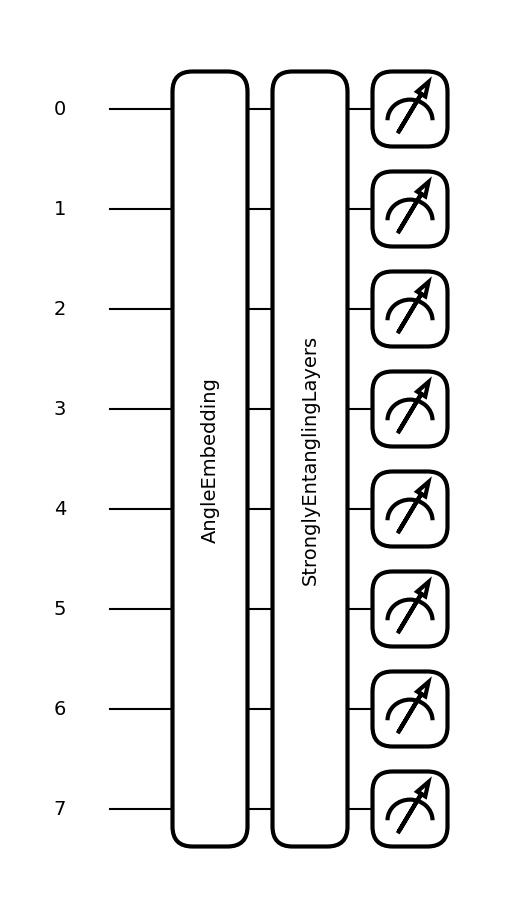

In [100]:
import matplotlib.pyplot as plt

# Pick a sample input of length NQ to visualize the circuit
x_example = np.zeros(NQ)  
w_example = np.zeros((2, NQ, 3))  
fig, ax = qml.draw_mpl(q_qnode)(x_example, w_example)
plt.show()

fig.savefig(ARTIFACTS_DIR / "qnn_circuit.png", dpi=300, bbox_inches="tight")


In [101]:
# Metrics and predictions
with torch.no_grad():
    tr_pred = qnn_model(torch.tensor(Xtr)).numpy()
    va_pred = qnn_model(torch.tensor(Xva)).numpy()
    te_pred = qnn_model(torch.tensor(Xte)).numpy()

qnn_tr = compute_metrics(ytr, tr_pred)
qnn_va = compute_metrics(yva, va_pred)
qnn_te = compute_metrics(yte, te_pred)
print('QNN metrics:')
print('  Train', qnn_tr)
print('  Val  ', qnn_va)
print('  Test ', qnn_te)

qnn_test_df = pd.DataFrame({'SMILES': smiles_te, 'y_true': yte, 'y_pred': te_pred})
qnn_test_df.to_csv(RESULTS_DIR / 'qnn_test_predictions.csv', index=False)

qnn_series_metrics: Dict[str, Dict[str, float]] = {}
for key, spec in SERIES.items():
    series_df, metrics = evaluate_series(key, spec, test_df, qnn_test_df)
    series_df.to_csv(RESULTS_DIR / f'qnn_series_{key}.csv', index=False)
    qnn_series_metrics[key] = metrics

qnn_summary = {'rmse': qnn_te['rmse'], 'mae': qnn_te['mae'], 'r2': qnn_te['r2'], 'runtime_sec': runtime_qnn}

QNN metrics:
  Train {'rmse': 1.5133661031723022, 'mae': 1.0708749294281006, 'r2': 0.557498574256897}
  Val   {'rmse': 1.6387438774108887, 'mae': 1.2150250673294067, 'r2': 0.6225725412368774}
  Test  {'rmse': 1.6325750350952148, 'mae': 1.1885449886322021, 'r2': 0.43044888973236084}


## Hybrid classical + quantum model

A small classical encoder feeds into a deeper strongly entangling quantum block before a linear regression head. Shares descriptor
inputs with the pure QNN to keep comparisons apples-to-apples.

In [102]:
PATIENCE = 10  # or whatever you want for the hybrid
history_hybrid: List[Dict[str, float]] = []

h_dev = qml.device('default.qubit', wires=NQ, shots=None)

def hybrid_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(NQ), rotation='X')
    qml.StronglyEntanglingLayers(weights, wires=range(NQ))
    return [qml.expval(qml.PauliZ(i)) for i in range(NQ)]

hyb_weight_shapes = {'weights': (3, NQ, 3)}
h_qnode = qml.QNode(hybrid_circuit, h_dev, interface='torch', diff_method='backprop')

class HybridReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(NQ, NQ),
            nn.ReLU(),
            nn.Linear(NQ, NQ),
        )
        self.q_layer = qml.qnn.TorchLayer(h_qnode, hyb_weight_shapes)
        self.head = nn.Linear(NQ, 1)

    def forward(self, x):
        enc = self.encoder(x)
        q_out = self.q_layer(enc)
        return self.head(q_out).squeeze(-1)

    def get_quantum_inputs(self, x):
        # helper for visualization later
        with torch.no_grad():
            return self.encoder(x)

hyb_model = HybridReg()
h_opt = torch.optim.Adam(hyb_model.parameters(), lr=5e-3)
crit = nn.MSELoss()

best_h = {'rmse': float('inf'), 'state': None}
start = time.perf_counter()
wait = 0  # epochs since last improvement

for epoch in range(1, 61):
    hyb_model.train()
    losses = []

    for xb, yb in train_tensor_ld:
        h_opt.zero_grad()
        pred = hyb_model(xb)
        loss = crit(pred, yb)
        loss.backward()
        h_opt.step()
        losses.append(loss.item())

    # validation 
    hyb_model.eval()
    with torch.no_grad():
        Xva_tensor = torch.tensor(Xva, dtype=torch.float32)  # ensure correct dtype
        yva_pred = hyb_model(Xva_tensor)
        yva_pred_np = yva_pred.detach().numpy()

    val_rmse = compute_metrics(yva, yva_pred_np)['rmse']
    history_hybrid.append({'epoch': epoch, 'train_loss': float(np.mean(batch_losses)), 'val_rmse': val_rmse})
    
    # early stopping 
    if val_rmse < best_h['rmse'] - 1e-4:
        best_h['rmse'] = val_rmse
        best_h['state'] = {k: v.detach().clone() for k, v in hyb_model.state_dict().items()}
        wait = 0  # reset patience on improvement
    else:
        wait += 1
        if wait >= PATIENCE:
            print(
                f"H-QNN early stopping at epoch {epoch} "
                f"(no val RMSE improvement for {PATIENCE} epochs). "
                f"Best val RMSE: {best_h['rmse']:.3f}"
            )
            break

    if epoch % 10 == 0:
        print(
            f"Hybrid epoch {epoch:03d} | "
            f"train loss {np.mean(losses):.4f} | val RMSE {val_rmse:.3f} | val R2 {val_r2:.3f}"
        )

runtime_hybrid = time.perf_counter() - start
print(f'Hybrid training runtime: {runtime_hybrid:.1f} sec')

if best_h['state'] is not None:
    hyb_model.load_state_dict(best_h['state'])

torch.save(hyb_model.state_dict(), ARTIFACTS_DIR / 'hybrid_weights.pt')
pd.DataFrame(history_qnn).to_csv(RESULTS_DIR / 'hybrid_history.csv', index=False)

Hybrid epoch 010 | train loss 1.7160 | val RMSE 1.289 | val R2 0.783
Hybrid epoch 020 | train loss 1.6512 | val RMSE 1.366 | val R2 0.783
Hybrid epoch 030 | train loss 1.6253 | val RMSE 1.231 | val R2 0.783
H-QNN early stopping at epoch 40 (no val RMSE improvement for 10 epochs). Best val RMSE: 1.231
Hybrid training runtime: 159.2 sec


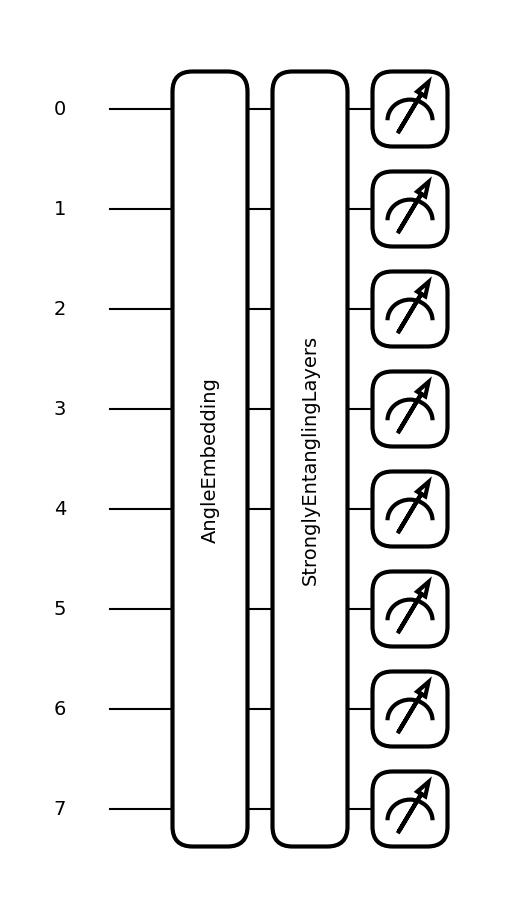

In [103]:
# One example input to show the circuit structure.
x_example = np.zeros(NQ)               # shape (NQ,)
w_example = np.zeros((3, NQ, 3))       # same as hyb_weight_shapes['weights']

fig, ax = qml.draw_mpl(h_qnode)(x_example, w_example)
plt.show()

# For the report:
fig.savefig(ARTIFACTS_DIR / "hybrid_qnn_circuit.png", dpi=300, bbox_inches="tight")


In [104]:
with torch.no_grad():
    tr_pred = hyb_model(torch.tensor(Xtr)).numpy()
    va_pred = hyb_model(torch.tensor(Xva)).numpy()
    te_pred = hyb_model(torch.tensor(Xte)).numpy()

hyb_tr = compute_metrics(ytr, tr_pred)
hyb_va = compute_metrics(yva, va_pred)
hyb_te = compute_metrics(yte, te_pred)
print('Hybrid metrics:')
print('  Train', hyb_tr)
print('  Val  ', hyb_va)
print('  Test ', hyb_te)

hyb_test_df = pd.DataFrame({'SMILES': smiles_te, 'y_true': yte, 'y_pred': te_pred})
hyb_test_df.to_csv(RESULTS_DIR / 'hybrid_test_predictions.csv', index=False)

hyb_series_metrics: Dict[str, Dict[str, float]] = {}
for key, spec in SERIES.items():
    series_df, metrics = evaluate_series(key, spec, test_df, hyb_test_df)
    series_df.to_csv(RESULTS_DIR / f'hybrid_series_{key}.csv', index=False)
    hyb_series_metrics[key] = metrics

hyb_summary = {'rmse': hyb_te['rmse'], 'mae': hyb_te['mae'], 'r2': hyb_te['r2'], 'runtime_sec': runtime_hybrid}

Hybrid metrics:
  Train {'rmse': 1.273919939994812, 'mae': 0.9008222818374634, 'r2': 0.686447024345398}
  Val   {'rmse': 1.2305636405944824, 'mae': 0.9030439257621765, 'r2': 0.7871764898300171}
  Test  {'rmse': 1.3662455081939697, 'mae': 0.9908822178840637, 'r2': 0.6011184453964233}


## Cross-model comparison

Collect the metrics and rough training runtime so the three approaches can be compared quickly. The CSV/PNG artifacts also live in
`results/` for easy inspection outside the notebook.

            rmse       mae        r2  runtime_sec
cnn     1.264229  0.931556  0.658463  1550.047085
qnn     1.632575  1.188545  0.430449    90.270287
hybrid  1.366246  0.990882  0.601118   159.221132


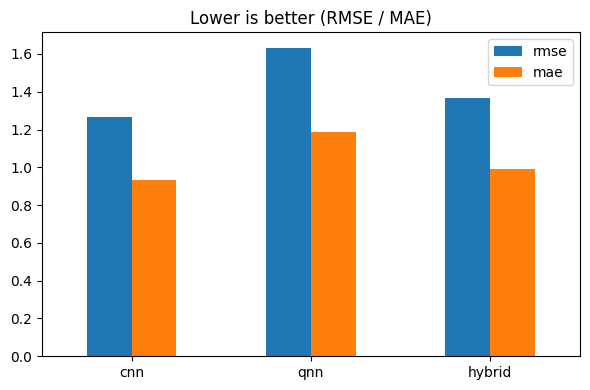

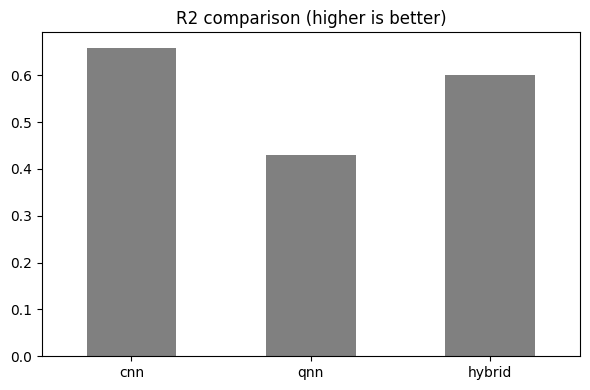

In [105]:
metrics_table = pd.DataFrame.from_dict(
    {
        'cnn': cnn_summary,
        'qnn': qnn_summary,
        'hybrid': hyb_summary,
    },
    orient='index',
)
metrics_table.to_csv(RESULTS_DIR / 'model_metrics.csv')
print(metrics_table)

plt.figure(figsize=(6, 4))
metrics_table[['rmse', 'mae']].plot(kind='bar', ax=plt.gca())
plt.title('Lower is better (RMSE / MAE)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
metrics_table['r2'].plot(kind='bar', color='gray')
plt.title('R2 comparison (higher is better)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()